# Homework 06

## Group 10

This week we are taking a look at two different CNN architectures, namely ResNet and DenseNet. After implementing simple versions of them, we will use them to perform image classification on the Cifar10 dataset we already used last week.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

Quickly recall the shape of our image data and take a look at the examples again.

In [3]:
train_images[0].shape

(32, 32, 3)

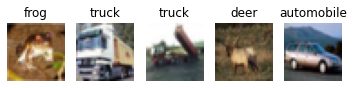

In [4]:
def class_names(label):
    """Little helper function to map a label to the corresponding word"""
    label_words = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return label_words[int(label)]

fig, ax = plt.subplots(1, 5)

for i in range(len(ax)):

    ax[i].imshow(train_images[i])
    ax[i].set_title(class_names(train_labels[i]))
    ax[i].axis("off")

# Input Pipeline

Here we are reusing the input pipeline from last week in which centered our images, normalized them and casted them into floats. The labels have been one-hot encoded and everything was zipped together and prefetched in batches.

In [5]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))


# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)


# Models

## ResNet

For the residual network we first define the `ResidualBlock` consisting of three convolutional layers followed by batch normalization.

When it comes to building the network itself, we dicided to keep it as modular as possbile to make testing as easy as possible.
You can pass the number of ResidualBlocks you want right into the constructor of the network, which will place them after the input layer. To quickly create our ResidualBlocks we used Pythons list comprehension abilities (called inline lists in this course). You can see that we made heavy use of lists here which allowed us to end up with a structure similar to what you whould achieve with the Keras Sequential Model API. All those lists are concatinated in the end so we can work through a single list in our call function.

In [6]:
# ResNet Model
from tensorflow.keras import layers

class ResidualBlock(layers.Layer):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.layers_list = [
            layers.Conv2D(channels, kernel_size=1, padding="same"),
            layers.BatchNormalization(),
            layers.Conv2D(channels, kernel_size=3, padding="same"),
            layers.BatchNormalization(),
            layers.Conv2D(channels, kernel_size=1, padding="same"),
            layers.BatchNormalization(),
            layers.Activation("relu")
        ]

    def call(self, x, training=False):
        orig_input = x
        for layer in self.layers_list:
            x = layer(x, training=training)
        return orig_input + x


class ResNet(tf.keras.Model):

    def __init__(self, res_block_count = 5):
        super(ResNet, self).__init__()
        self.res_block_count = res_block_count

        # Input through a convolutional layer
        input_layer = [
            layers.Conv2D(32, kernel_size=3, input_shape=(32,32,3))
        ]

        # Add an arbitratiy number of Residual blocks
        residual_blocks = [ResidualBlock(32) for _ in range(self.res_block_count)]

        # Define the output layer
        output_layer = [
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(10, activation="softmax")
        ]

        # Join all our layers together
        self.layers_list = input_layer + residual_blocks + output_layer

    # @tf.function
    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


We instanciate an example network with 5 ResidualBlocks and want to take a look at its structure and parameters. However we need to build our model first to create its weights. When starting the training process the model is built automatically. However, when we want to see our structure without training we need to call the `Model.build()` method and supply an input shape which will create the weights for us. Recall that our data is shaped like __(minibatch_size, pixels, pixels, channels)__, which is why we used __(64,32,32,3)__ in this example.

If you try to call `Model.summary()` before, Tensorflow will tell you to build the model first by training it on some data.

In [7]:
resnet = ResNet(5)
resnet.build((64,32,32,3))
resnet.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
residual_block (ResidualBloc multiple                  11744     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  11744     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  11744     
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  11744     
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  11744     
_________________________________________________________________
batch_normalization_15 (Batc multiple                  128 

## DenseNet

In [8]:
# DenseNet Model

class TransitionLayer(layers.Layer):
    def __init__(self):
        super(TransitionLayer, self).__init__()
        
        self.layers_list = [
            layers.Conv2D(64, kernel_size=1),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.AveragePooling2D(),
        ]

    def call(self, x, training = False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


class Block(layers.Layer):
    def __init__(self):
        super(DenseBlock, self).__init__()
        
        self.layer_list = [
            layers.Conv2D(16, kernel_size=3),
            layers.BatchNormalization(),
            layers.Activation("relu"),
        ]


    def call(self, x, training = False):
        pass


class DenseBlock(layers.Layer):
    def __init__(self):
        super(DenseBlock, self).__init__()
        


    def call(self, x, training = False):
        pass


class DenseNet(tf.keras.Model):
    def __init__(self, depth):
        super(DenseNet, self).__init__()

        
        # Define the input Layer
        input_layer = [
            layers.Conv2D(32, kernel_size=3, input_shape=(32,32,3))
        ]

        # Create alternating sequence of dense blocks and transition layers
        layer_list = []
        for i in range(depth - 1):
            layer_list.append(DenseBlock())
            layer_list.append(TransitionLayer())
        layer_list.append(DenseBlock) # No transition layer after the last dense block

        # Define the output layer
        output_layer = [
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(10, activation="softmax"),
        ]

        self.layers_list = input_layers + layer_list + output_layer

    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x


# Training

For convinience we will make our usual training functions a bit more modular. First lets define our helper functions.

In [9]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [10]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [11]:
import time
%matplotlib inline

def train_model(model, loss_function, epochs, learning_rate, optimizer):
    tf.keras.backend.clear_session()

    model = model

    running_average_factor = 0.95

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    test_accuracies = []

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        start = time.perf_counter()
        
        #print('Epoch: __ ' + str(epoch))
        #training (and checking in with training)
        running_average = 0
        for (input,target) in train_dataset:
            train_loss = train_step(model, input, target, loss_function, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)

        #testing
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        end = time.perf_counter()
        plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

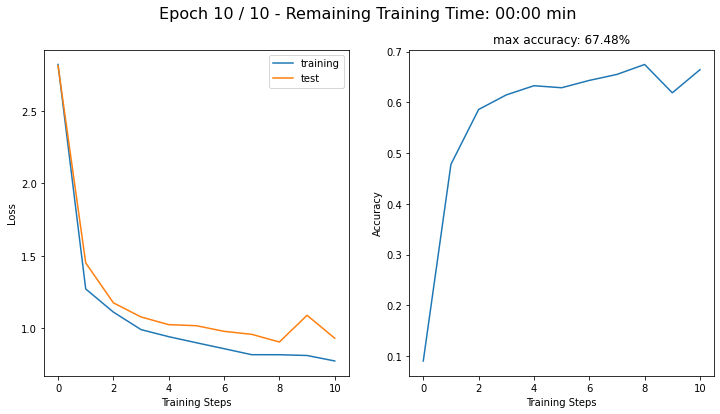

In [12]:
### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Train on ResNet
train_model(
    model = ResNet(5),
    loss_function = tf.keras.losses.CategoricalCrossentropy(),
    epochs = num_epochs,
    learning_rate = learning_rate,
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    )


In [13]:
# Train on DenseNet

# train_model(
#     model = DenseNet(5),
#     loss_function = tf.keras.losses.CategoricalCrossentropy(),
#     epochs = num_epochs,
#     learning_rate = learning_rate,
#     optimizer = tf.keras.optimizers.Adam(learning_rate),
#     )